MSD-I dataset (mapping, metadata, annotations and links to images)
Data splits and feature vectors for TISMIR single-label classification experiments 

In [3]:
import numpy as np
import pandas as pd
import json
import tqdm
from collections import Counter
import collections

In [4]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Load clean dataset

In [5]:
dataset_clean = pd.read_csv("dataset_clean.csv")

In [6]:
dataset_clean.head()

,msd_track_id,genre,album_index,set,msd_artist_id,image_url,song_title,song_lyrics,artist,lyrics_link,lyrics_text,lyrics
0,TRABKJU128F422A7FE,Metal,0,train,ARBD4QW1187FB42153,http://artwork-cdn.7static.com/static/img/slee...,The Illusionist,NaN,Scar Symmetry,https://www.lyricsfreak.com/s/scar+symmetry/th...,as an outcast i paced defeat seeking comfort i...,as an outcast i paced defeat seeking comfort i...
1,TRDMMDE128F14A9052,Rock,2,train,ARJVTRE1187B9959C0,http://artwork-cdn.7static.com/static/img/slee...,Weekend Driver,NaN,Foghat,https://www.lyricsfreak.com/f/foghat/weekend+d...,dave peverett - riff bros. music - ascap waiti...,dave peverett - riff bros. music - ascap waiti...
2,TRJOPZB128F4250E02,Rock,4,train,AR62BB21187B9AC83D,http://artwork-cdn.7static.com/static/img/slee...,Too Alive,NaN,The Breeders,https://www.lyricsfreak.com/b/breeders/too+ali...,i took off when will will make no way steal it...,i took off when will will make no way steal it...
3,TRJKBVL128F935567B,Rock,5,train,AR7GVOV1187B9B5FF1,http://artwork-cdn.7static.com/static/img/slee...,Ride The Darker Wave,NaN,Sebadoh,https://www.lyricsfreak.com/s/sebadoh/ride+the...,you make your words so nice i'm waiting you to...,you make your words so nice i'm waiting you to...
4,TRUSOQD128F92CFEA5,Rock,7,train,ARZHQDD1187FB5B871,http://artwork-cdn.7static.com/static/img/slee...,Carmen,Last night she ran away \nLeft a letter by th...,Lush,https://www.lyricsfreak.com/l/lush/carmen_2008...,(anderson/berenyi) carmen tells me what she's ...,(anderson/berenyi) carmen tells me what she's ...


# Stats

In [ ]:
train_stats = Counter(dataset_clean[dataset_clean.set == 'train'].genre)
train_stats = collections.OrderedDict(sorted(train_stats.items()))

In [ ]:
val_stats = Counter(dataset_clean[dataset_clean.set == 'val'].genre)
val_stats = collections.OrderedDict(sorted(val_stats.items()))

In [ ]:
test_stats = Counter(dataset_clean[dataset_clean.set == 'test'].genre)
test_stats = collections.OrderedDict(sorted(test_stats.items()))

In [ ]:
len(train_stats)

In [ ]:
train_stats

In [ ]:
train_stats.keys()

In [ ]:
" ".join(train_stats.keys())

In [ ]:
val_stats

In [ ]:
test_stats

In [ ]:
plt.figure(figsize=(16, 12))

plt.subplot(3, 1, 1)
plt.bar(list(train_stats.keys()), train_stats.values())
plt.title('Тренировочная выборка')
plt.ylabel('Количество песен')

plt.subplot(3, 1, 2)
plt.bar(list(val_stats.keys()), val_stats.values())
plt.title('Валидационная выборка')
plt.ylabel('Количество песен')

plt.subplot(3, 1, 3)
plt.bar(list(test_stats.keys()), test_stats.values())
plt.title('Тестовая выборка')
plt.ylabel('Количество песен')
plt.savefig('train_test_split.jpg')
plt.show()

# Preprocess text

In [7]:
from time import time
import numpy as np
import string

from techniques import *

In [8]:
finalTokens = [] # all tokens
stoplist = stopwords.words('english')

In [9]:
lemmatizer = WordNetLemmatizer() # set lemmatizer
stemmer = PorterStemmer() # set stemmer

In [134]:
def tokenize(text):
    finalTokens = []
    totalAdjectives = 0
    totalAdverbs = 0
    totalVerbs = 0
    onlyOneSentenceTokens = [] # tokens of one sentence each time

    tokens = nltk.word_tokenize(text)
    
    tokens = replaceNegations(tokens) # Technique 6: finds "not" and antonym for the next word and if found, replaces not and the next word with the antonym
    
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator) # Technique 7: remove punctuation

    tokens = nltk.word_tokenize(text) # it takes a text as an input and provides a list of every token in it
    
### NO POS TAGGING BEGIN (If you don't want to use POS Tagging keep this section uncommented) ###
    
    for w in tokens:

        if (w not in stoplist): # Technique 10: remove stopwords
            final_word = addCapTag(w) # Technique 8: Finds a word with at least 3 characters capitalized and adds the tag ALL_CAPS_
            
            final_word = final_word.lower() # Technique 9: lowercases all characters

            final_word = replaceElongated(final_word) # Technique 11: replaces an elongated word with its basic form, unless the word exists in the lexicon
            
            #if len(final_word)>1:
            #    final_word = spellCorrection(final_word) # Technique 12: correction of spelling errors
            final_word = lemmatizer.lemmatize(final_word) # Technique 14: lemmatizes words
            #final_word = stemmer.stem(final_word) # Technique 15: apply stemming to words


            
            onlyOneSentenceTokens.append(final_word)           
            finalTokens.append(final_word)

         
    onlyOneSentence = " ".join(onlyOneSentenceTokens) # form again the sentence from the list of tokens
    #print(onlyOneSentence) # print final sentence

    
    """ Write the preprocessed text to file """
    #with open("result.txt", "a") as result:
    #    result.write(textID+"\t"+y+"\t"+onlyOneSentence+"\n")
        
    return finalTokens

In [135]:
def preprocess(text):
    text = replaceURL(text) # Technique 1
    text = replaceAtUser(text) # Technique 1
    text = removeHashtagInFrontOfWord(text) # Technique 1

    temp_slangs, temp_slangsFound = countSlang(text)
    #totalSlangs += temp_slangs # total slangs for all sentences
    #for word in temp_slangsFound:
    #    totalSlangsFound.append(word) # all the slangs found in all sentences

    text = replaceSlang(text) # Technique 2: replaces slang words and abbreviations with their equivalents
    text = replaceContraction(text) # Technique 3: replaces contractions to their equivalents
    text = removeNumbers(text) # Technique 4: remove integers from text

    emoticons = countEmoticons(text) # how many emoticons in this sentence
    #totalEmoticons += emoticons

    text = removeEmoticons(text) # removes emoticons from text


    #totalAllCaps += countAllCaps(text)

    #totalMultiExclamationMarks += countMultiExclamationMarks(text) # how many repetitions of exlamation marks in this sentence
    #totalMultiQuestionMarks += countMultiQuestionMarks(text) # how many repetitions of question marks in this sentence
    #totalMultiStopMarks += countMultiStopMarks(text) # how many repetitions of stop marks in this sentence

    text = replaceMultiExclamationMark(text) # Technique 5: replaces repetitions of exlamation marks with the tag "multiExclamation"
    text = replaceMultiQuestionMark(text) # Technique 5: replaces repetitions of question marks with the tag "multiQuestion"
    text = replaceMultiStopMark(text) # Technique 5: replaces repetitions of stop marks with the tag "multiStop"

    #totalElongated += countElongated(text)
    tokens = tokenize(text) 
    sentense = " ".join(tokens)
    return sentense

# Preprocess

https://github.com/Deffro/text-preprocessing-techniques

In [137]:
preprocess(dataset_clean.at[5, 'lyrics'])

'hair soft drifted snow death white would like know hate give got sky turn green grass several shade blue every member parliament trip glue sky turn green grass several shade blue every member parliament trip glue take thing time till sugar spun sister happy love mine take thing oh much paid fifteen gut take many hand stuck jean know know must mean wake sun asked fuss gave thought wake sun think done gave thought would oh take thing time till sugar spun sister happy love mine yeah yeah yeah candy floss girl sticky fingered boy oh sister mine yeah'

In [138]:
preprocess(dataset_clean.at[1, 'lyrics'])

'dave peveret riff bros music ascap waitin weekend soon comin around hangin best friend glad found weekday emotion gon na leave em behind get together crazy time talkin bout weekend driver live without talkin bout weekend driver yeah waitin weekend watch clock wall throw deep end hear call workin week survivor cool refined get together another kind talkin bout weekend driver live without talkin bout weekend driver yeah matter far go back work monday weekend another memory yeah didgerido erik slide solo talkin bout weekend driver live without talkin bout weekend driver yeah talkin bout weekend driver live without yeah talkin bout weekend driver yeah yeaeyeah oh yeah yeah oh yeah yeaeyeah'

In [139]:
for i in tqdm.tqdm(dataset_clean.index):
    dataset_clean.at[i, 'lyrics_clean_without_stem'] = preprocess(dataset_clean.at[i, 'lyrics'])

100%|██████████| 10382/10382 [01:29<00:00, 116.31it/s]


In [140]:
dataset_clean

,msd_track_id,genre,album_index,set,msd_artist_id,image_url,song_title,song_lyrics,artist,lyrics_link,lyrics_text,lyrics,lyrics_clean,lyrics_clean_without_stem
0,TRABKJU128F422A7FE,Metal,0,train,ARBD4QW1187FB42153,http://artwork-cdn.7static.com/static/img/slee...,The Illusionist,NaN,Scar Symmetry,https://www.lyricsfreak.com/s/scar+symmetry/th...,as an outcast i paced defeat seeking comfort i...,as an outcast i paced defeat seeking comfort i...,outcast pace defeat seek comfort pain retreat ...,outcast paced defeat seeking comfort painful r...
1,TRDMMDE128F14A9052,Rock,2,train,ARJVTRE1187B9959C0,http://artwork-cdn.7static.com/static/img/slee...,Weekend Driver,NaN,Foghat,https://www.lyricsfreak.com/f/foghat/weekend+d...,dave peverett - riff bros. music - ascap waiti...,dave peverett - riff bros. music - ascap waiti...,dave peveret riff bro music ascap waitin weeke...,dave peveret riff bros music ascap waitin week...
2,TRJOPZB128F4250E02,Rock,4,train,AR62BB21187B9AC83D,http://artwork-cdn.7static.com/static/img/slee...,Too Alive,NaN,The Breeders,https://www.lyricsfreak.com/b/breeders/too+ali...,i took off when will will make no way steal it...,i took off when will will make no way steal it...,took make way steal like found speed mic shut ...,took make way steal like found speed mic shut ...
3,TRJKBVL128F935567B,Rock,5,train,AR7GVOV1187B9B5FF1,http://artwork-cdn.7static.com/static/img/slee...,Ride The Darker Wave,NaN,Sebadoh,https://www.lyricsfreak.com/s/sebadoh/ride+the...,you make your words so nice i'm waiting you to...,you make your words so nice i'm waiting you to...,make word nice wait name price one walk along ...,make word nice waiting name price one walk alo...
4,TRUSOQD128F92CFEA5,Rock,7,train,ARZHQDD1187FB5B871,http://artwork-cdn.7static.com/static/img/slee...,Carmen,Last night she ran away \nLeft a letter by th...,Lush,https://www.lyricsfreak.com/l/lush/carmen_2008...,(anderson/berenyi) carmen tells me what she's ...,(anderson/berenyi) carmen tells me what she's ...,andersonberenyi carmen tell done say fun want ...,andersonberenyi carmen tell done say fun want ...
5,TRRNTLC128F93366F6,Rock,11,train,ARTNHBW1187B9A5482,http://artwork-cdn.7static.com/static/img/slee...,Sugar Spun Sister,Her hair \nSoft drifted snow \nDeath white ...,The Stone Roses,https://www.lyricsfreak.com/s/stone+roses/suga...,her hair soft drifted snow death white i'd lik...,her hair soft drifted snow death white i'd lik...,hair soft drift snow death white would like kn...,hair soft drifted snow death white would like ...
6,TRHDZSB128F429112F,Metal,13,train,ARZN98V1187B990D1D,http://artwork-cdn.7static.com/static/img/slee...,Emerald crown,NaN,THERION,https://www.lyricsfreak.com/t/therion/emerald+...,during the war that took place in heaven the b...,during the war that took place in heaven the b...,war took place heaven brightest star lost prec...,war took place heaven brightest star lost prec...
7,TRYDOAY128E0794924,Rock,14,train,ARKL75U1187FB5B8B6,http://artwork-cdn.7static.com/static/img/slee...,Closer To Free (Live),NaN,BoDeans,https://www.lyricsfreak.com/b/bodeans/closer+t...,yeah everybody wants to live how they wanna li...,yeah everybody wants to live how they wanna li...,yeah everybodi want live want live everybodi w...,yeah everybody want live want live everybody w...
8,TRAQKWU128F4251685,Rock,16,train,ARYMCJZ1187FB513DA,http://artwork-cdn.7static.com/static/img/slee...,Penelope,Penelope works in the market \nDown in the co...,Of Montreal,https://www.lyricsfreak.com/o/of+montreal/pene...,penelope shoot the apple off my head i need to...,penelope shoot the apple off my head i need to...,penelop shoot appl head need go store get slee...,penelope shoot apple head need go store get sl...
9,TREXUGD128F1460F54,Rock,18,train,AR00RBU1187B9B3F1F,http://artwork-cdn.7static.com/static/img/slee...,Only Meant To Say,NaN,Matthew Jay,https://www.lyricsfreak.com/m/matthew+jay/only...,everything could die tomorrow would you still ...,everything could die tomorr

In [141]:
dataset_clean.shape

(10382, 14)

In [142]:
dataset_clean.dropna(subset=['lyrics_clean_without_stem']).shape

(10382, 14)

In [143]:
dataset_clean.dropna(subset=['lyrics_clean']).shape

(10382, 14)

In [144]:
dataset_clean.to_csv("dataset_clean_2.csv")

In [145]:
dataset_clean.to_csv("/data/AGE_DATA/dataset_clean_2.csv")

In [259]:
dataset_clean = pd.read_csv("/data/AGE_DATA/dataset_clean_2.csv")

# TFIDF

# Sample use

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
corpus = [
     'This is the first document.',
     'This document is the second document.',
     'And this is the third one.',
     'Is this the first document?',
]

In [ ]:
vectorizer = TfidfVectorizer()

In [ ]:
X = vectorizer.fit_transform(corpus)

In [ ]:
X.shape

In [ ]:
y = [1, 2, 3, 1]

# Baseline

In [49]:
LABEL_TO_INDEX = {'Blues': 0,
 'Country': 1,
 'Electronic': 2,
 'Folk': 3,
 'Jazz': 4,
 'Latin': 5,
 'Metal': 6,
 'New Age': 7,
 'Pop': 8,
 'Punk': 9,
 'Rap': 10,
 'Reggae': 11,
 'RnB': 12,
 'Rock': 13,
 'World': 14}

In [43]:
vectorizer = TfidfVectorizer()

In [260]:
dataset_clean.lyrics_clean[dataset_clean.set == 'train'].values.shape

(8332,)

In [45]:
vectorizer.fit(dataset_clean.lyrics_clean[dataset_clean.set == 'train'].values)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [47]:
X = vectorizer.transform(dataset_clean.lyrics_clean[dataset_clean.set == 'train'].values)

In [48]:
X.shape

(8332, 39419)

In [256]:
len(y_train)

8332

In [50]:
y_train = [LABEL_TO_INDEX[x] for x in dataset_clean.genre[dataset_clean.set == 'train']]

In [52]:
Counter(y_train)

Counter({6: 724,
         13: 2297,
         4: 543,
         2: 684,
         8: 1153,
         12: 555,
         5: 72,
         1: 627,
         10: 646,
         11: 312,
         3: 304,
         9: 204,
         0: 137,
         14: 32,
         7: 42})

# Log reg

In [53]:
from sklearn.linear_model import LogisticRegression

In [54]:
model = LogisticRegression(solver='lbfgs')

In [55]:
model.fit(X, y_train)

/home/fedor.kitashov/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [56]:
y_pred_train = model.predict(X)

In [57]:
Counter(y_pred_train)

Counter({13: 4680,
         6: 478,
         12: 272,
         8: 1166,
         4: 368,
         10: 501,
         5: 59,
         1: 328,
         2: 438,
         11: 22,
         9: 5,
         3: 9,
         0: 6})

# Evaluate

In [58]:
from sklearn.metrics import classification_report

In [61]:
report_train = classification_report(y_train, y_pred_train)

In [62]:
print (report_train)

              precision    recall  f1-score   support

           0       1.00      0.04      0.08       137
           1       0.60      0.31      0.41       627
           2       0.48      0.31      0.38       684
           3       1.00      0.03      0.06       304
           4       0.56      0.38      0.45       543
           5       0.61      0.50      0.55        72
           6       0.78      0.52      0.62       724
           7       0.00      0.00      0.00        42
           8       0.46      0.46      0.46      1153
           9       1.00      0.02      0.05       204
          10       0.70      0.54      0.61       646
          11       0.91      0.06      0.12       312
          12       0.50      0.25      0.33       555
          13       0.46      0.94      0.62      2297
          14       0.00      0.00      0.00        32

    accuracy                           0.51      8332
   macro avg       0.60      0.29      0.32      8332
weighted avg       0.58   

### Validation

In [66]:
X_val = vectorizer.transform(dataset_clean.lyrics_clean[dataset_clean.set == 'val'].values)

In [65]:
y_val = [LABEL_TO_INDEX[x] for x in dataset_clean.genre[dataset_clean.set == 'val']]

In [67]:
y_pred_val = model.predict(X_val)

In [68]:
Counter(y_pred_val)

Counter({8: 296,
         4: 106,
         2: 131,
         12: 54,
         6: 56,
         13: 252,
         10: 51,
         1: 54,
         3: 2,
         11: 1,
         9: 1})

In [69]:
report_val = classification_report(y_val, y_pred_val)

/home/fedor.kitashov/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [72]:
print (report_val)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.15      0.12      0.13        66
           2       0.16      0.21      0.18       102
           3       0.00      0.00      0.00        33
           4       0.19      0.19      0.19       105
           5       0.00      0.00      0.00         1
           6       0.34      0.19      0.24       100
           7       0.00      0.00      0.00        25
           8       0.25      0.36      0.30       209
           9       0.00      0.00      0.00        21
          10       0.37      0.30      0.33        63
          11       0.00      0.00      0.00        33
          12       0.15      0.10      0.12        78
          13       0.16      0.30      0.21       137
          14       0.00      0.00      0.00         3

    accuracy                           0.21      1004
   macro avg       0.12      0.12      0.11      1004
weighted avg       0.19   

# Test

In [73]:
X_test = vectorizer.transform(dataset_clean.lyrics_clean[dataset_clean.set == 'test'].values)

In [74]:
y_test = [LABEL_TO_INDEX[x] for x in dataset_clean.genre[dataset_clean.set == 'test']]

In [75]:
y_pred_test = model.predict(X_test)

In [77]:
report_test = classification_report(y_test, y_pred_test)

In [83]:
print (report_test)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        45
           1       0.08      0.08      0.08        48
           2       0.15      0.19      0.17       102
           3       0.00      0.00      0.00        24
           4       0.19      0.17      0.18       121
           5       0.00      0.00      0.00         3
           6       0.23      0.24      0.24        58
           7       0.00      0.00      0.00         8
           8       0.21      0.36      0.26       169
           9       0.00      0.00      0.00        10
          10       0.32      0.29      0.30        79
          11       1.00      0.02      0.03        64
          12       0.16      0.08      0.11       118
          13       0.22      0.30      0.25       194
          14       0.00      0.00      0.00         3

    accuracy                           0.20      1046
   macro avg       0.17      0.12      0.11      1046
weighted avg       0.23   

# Усложним tfidf

In [86]:
vectorizer = TfidfVectorizer(ngram_range=(1,4))

In [87]:
dataset_clean.lyrics_clean[dataset_clean.set == 'train'].values.shape

(8332,)

In [88]:
vectorizer.fit(dataset_clean.lyrics_clean[dataset_clean.set == 'train'].values)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 4), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [89]:
X = vectorizer.transform(dataset_clean.lyrics_clean[dataset_clean.set == 'train'].values)

In [90]:
X.shape

(8332, 1879408)

In [91]:
y_train = [LABEL_TO_INDEX[x] for x in dataset_clean.genre[dataset_clean.set == 'train']]

# Log reg

In [93]:
from sklearn.linear_model import LogisticRegression

In [94]:
model = LogisticRegression()

In [95]:
model.fit(X, y_train)

/home/fedor.kitashov/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/fedor.kitashov/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [96]:
y_pred_train = model.predict(X)

In [97]:
Counter(y_pred_train)

Counter({13: 5749,
         4: 223,
         8: 1038,
         2: 321,
         10: 397,
         12: 198,
         6: 244,
         1: 134,
         5: 10,
         11: 11,
         0: 4,
         3: 3})

# Evaluate

In [98]:
from sklearn.metrics import classification_report

In [99]:
report_train = classification_report(y_train, y_pred_train)

/home/fedor.kitashov/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [100]:
print (report_train)

              precision    recall  f1-score   support

           0       1.00      0.03      0.06       137
           1       0.90      0.19      0.32       627
           2       0.78      0.36      0.50       684
           3       1.00      0.01      0.02       304
           4       0.83      0.34      0.49       543
           5       1.00      0.14      0.24        72
           6       0.96      0.32      0.49       724
           7       0.00      0.00      0.00        42
           8       0.70      0.63      0.66      1153
           9       0.00      0.00      0.00       204
          10       0.85      0.52      0.64       646
          11       0.82      0.03      0.06       312
          12       0.84      0.30      0.44       555
          13       0.40      0.99      0.57      2297
          14       0.00      0.00      0.00        32

    accuracy                           0.52      8332
   macro avg       0.67      0.26      0.30      8332
weighted avg       0.69   

### Validation

In [101]:
X_val = vectorizer.transform(dataset_clean.lyrics_clean[dataset_clean.set == 'val'].values)

In [102]:
y_val = [LABEL_TO_INDEX[x] for x in dataset_clean.genre[dataset_clean.set == 'val']]

In [103]:
y_pred_val = model.predict(X_val)

In [104]:
Counter(y_pred_val)

Counter({8: 431, 13: 333, 2: 66, 12: 39, 4: 48, 10: 47, 6: 27, 1: 13})

In [105]:
report_val = classification_report(y_val, y_pred_val)

In [106]:
print (report_val)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.31      0.06      0.10        66
           2       0.18      0.12      0.14       102
           3       0.00      0.00      0.00        33
           4       0.17      0.08      0.10       105
           5       0.00      0.00      0.00         1
           6       0.44      0.12      0.19       100
           7       0.00      0.00      0.00        25
           8       0.25      0.51      0.33       209
           9       0.00      0.00      0.00        21
          10       0.40      0.30      0.35        63
          11       0.00      0.00      0.00        33
          12       0.13      0.06      0.09        78
          13       0.16      0.38      0.22       137
          14       0.00      0.00      0.00         3

    accuracy                           0.22      1004
   macro avg       0.14      0.11      0.10      1004
weighted avg       0.21   

# Test

In [107]:
X_test = vectorizer.transform(dataset_clean.lyrics_clean[dataset_clean.set == 'test'].values)

In [108]:
y_test = [LABEL_TO_INDEX[x] for x in dataset_clean.genre[dataset_clean.set == 'test']]

In [109]:
y_pred_test = model.predict(X_test)

In [110]:
report_test = classification_report(y_test, y_pred_test)

In [111]:
print (report_test)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        45
           1       0.18      0.04      0.07        48
           2       0.14      0.09      0.11       102
           3       0.00      0.00      0.00        24
           4       0.25      0.09      0.13       121
           5       0.00      0.00      0.00         3
           6       0.29      0.12      0.17        58
           7       0.00      0.00      0.00         8
           8       0.19      0.50      0.27       169
           9       0.00      0.00      0.00        10
          10       0.32      0.29      0.31        79
          11       0.00      0.00      0.00        64
          12       0.20      0.06      0.09       118
          13       0.20      0.37      0.26       194
          14       0.00      0.00      0.00         3

    accuracy                           0.21      1046
   macro avg       0.12      0.10      0.09      1046
weighted avg       0.18   

# Усложним модель

In [114]:
from xgboost import XGBClassifier

In [116]:
model = XGBClassifier(n_jobs=8)

# Train

In [117]:
model.fit(X, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=8, nthread=None, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [118]:
y_pred_train = model.predict(X)

In [119]:
Counter(y_pred_train)

Counter({6: 402,
         13: 4582,
         4: 425,
         8: 1200,
         12: 283,
         5: 65,
         2: 419,
         10: 502,
         1: 226,
         11: 78,
         0: 60,
         14: 12,
         9: 20,
         3: 51,
         7: 7})

# Evaluate

In [120]:
from sklearn.metrics import classification_report

In [121]:
report_train = classification_report(y_train, y_pred_train)

In [122]:
print (report_train)

              precision    recall  f1-score   support

           0       0.92      0.40      0.56       137
           1       0.79      0.28      0.42       627
           2       0.56      0.34      0.43       684
           3       0.92      0.15      0.26       304
           4       0.59      0.46      0.52       543
           5       0.97      0.88      0.92        72
           6       0.75      0.42      0.54       724
           7       0.71      0.12      0.20        42
           8       0.41      0.43      0.42      1153
           9       1.00      0.10      0.18       204
          10       0.81      0.63      0.71       646
          11       0.87      0.22      0.35       312
          12       0.75      0.38      0.50       555
          13       0.47      0.95      0.63      2297
          14       0.92      0.34      0.50        32

    accuracy                           0.54      8332
   macro avg       0.76      0.41      0.48      8332
weighted avg       0.63   

### Validation

In [123]:
X_val = vectorizer.transform(dataset_clean.lyrics_clean[dataset_clean.set == 'val'].values)

In [124]:
y_val = [LABEL_TO_INDEX[x] for x in dataset_clean.genre[dataset_clean.set == 'val']]

In [125]:
y_pred_val = model.predict(X_val)

In [126]:
Counter(y_pred_val)

Counter({6: 86,
         8: 317,
         4: 174,
         2: 132,
         13: 123,
         12: 55,
         10: 29,
         1: 60,
         0: 7,
         3: 8,
         14: 1,
         11: 11,
         9: 1})

In [127]:
report_val = classification_report(y_val, y_pred_val)

/home/fedor.kitashov/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [128]:
print (report_val)

              precision    recall  f1-score   support

           0       0.14      0.04      0.06        28
           1       0.20      0.18      0.19        66
           2       0.13      0.17      0.15       102
           3       0.12      0.03      0.05        33
           4       0.19      0.31      0.24       105
           5       0.00      0.00      0.00         1
           6       0.29      0.25      0.27       100
           7       0.00      0.00      0.00        25
           8       0.24      0.36      0.29       209
           9       0.00      0.00      0.00        21
          10       0.48      0.22      0.30        63
          11       0.00      0.00      0.00        33
          12       0.09      0.06      0.08        78
          13       0.20      0.18      0.18       137
          14       0.00      0.00      0.00         3

    accuracy                           0.21      1004
   macro avg       0.14      0.12      0.12      1004
weighted avg       0.20   

# Test

In [129]:
X_test = vectorizer.transform(dataset_clean.lyrics_clean[dataset_clean.set == 'test'].values)

In [130]:
y_test = [LABEL_TO_INDEX[x] for x in dataset_clean.genre[dataset_clean.set == 'test']]

In [131]:
y_pred_test = model.predict(X_test)

In [132]:
report_test = classification_report(y_test, y_pred_test)

In [133]:
print (report_test)

              precision    recall  f1-score   support

           0       0.44      0.09      0.15        45
           1       0.05      0.06      0.06        48
           2       0.12      0.16      0.14       102
           3       0.00      0.00      0.00        24
           4       0.21      0.25      0.23       121
           5       0.00      0.00      0.00         3
           6       0.16      0.22      0.19        58
           7       0.00      0.00      0.00         8
           8       0.21      0.43      0.28       169
           9       0.00      0.00      0.00        10
          10       0.41      0.25      0.31        79
          11       0.30      0.09      0.14        64
          12       0.18      0.08      0.11       118
          13       0.23      0.18      0.20       194
          14       0.00      0.00      0.00         3

    accuracy                           0.20      1046
   macro avg       0.15      0.12      0.12      1046
weighted avg       0.21   

# Confusion matrix

In [198]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)


    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



In [159]:
from sklearn.metrics import confusion_matrix

In [151]:
test_confusion = confusion_matrix(y_test, y_pred_test)

In [156]:
list(LABEL_TO_INDEX.keys())

['Blues',
 'Country',
 'Electronic',
 'Folk',
 'Jazz',
 'Latin',
 'Metal',
 'New Age',
 'Pop',
 'Punk',
 'Rap',
 'Reggae',
 'RnB',
 'Rock',
 'World']

In [162]:
y_test

[8,
 2,
 13,
 13,
 13,
 8,
 2,
 13,
 12,
 13,
 13,
 13,
 13,
 13,
 3,
 10,
 8,
 13,
 11,
 0,
 0,
 10,
 13,
 13,
 2,
 13,
 12,
 8,
 13,
 10,
 12,
 13,
 13,
 13,
 13,
 13,
 10,
 8,
 8,
 13,
 13,
 13,
 4,
 13,
 10,
 11,
 8,
 0,
 12,
 13,
 12,
 2,
 0,
 8,
 13,
 10,
 13,
 13,
 11,
 6,
 10,
 12,
 12,
 13,
 13,
 10,
 13,
 13,
 1,
 11,
 13,
 4,
 2,
 10,
 13,
 13,
 13,
 3,
 13,
 2,
 13,
 10,
 8,
 13,
 13,
 13,
 13,
 12,
 6,
 13,
 13,
 13,
 13,
 6,
 6,
 3,
 2,
 13,
 13,
 8,
 4,
 13,
 13,
 6,
 13,
 13,
 13,
 13,
 12,
 1,
 13,
 8,
 11,
 13,
 13,
 13,
 13,
 13,
 13,
 10,
 13,
 1,
 13,
 13,
 0,
 3,
 13,
 1,
 13,
 13,
 3,
 13,
 13,
 4,
 8,
 4,
 13,
 12,
 13,
 13,
 13,
 4,
 12,
 10,
 13,
 6,
 13,
 13,
 4,
 13,
 4,
 1,
 13,
 4,
 13,
 13,
 1,
 13,
 13,
 8,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 11,
 13,
 13,
 2,
 0,
 4,
 13,
 13,
 13,
 8,
 6,
 13,
 13,
 0,
 1,
 13,
 13,
 1,
 13,
 2,
 11,
 8,
 13,
 13,
 13,
 13,
 13,
 10,
 13,
 8,
 11,
 13,
 13,
 2,
 12,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13

In [164]:
y_pred_test.dtype

dtype('int64')

Confusion matrix, without normalization
[[ 4  4  4  0  6  0  2  0 16  0  0  2  3  4  0]
 [ 1  3  5  0  7  0  1  0 16  0  1  3  1 10  0]
 [ 0  6 16  0 14  0  8  0 35  0  3  3  5 12  0]
 [ 0  2  4  0  4  0  2  0  7  0  0  0  3  2  0]
 [ 1  5 13  1 30  0 12  0 30  0  2  0  8 17  2]
 [ 0  1  0  0  2  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  6  0  8  0 13  0 19  0  3  0  1  6  0]
 [ 0  1  1  0  2  0  1  0  0  0  0  0  1  2  0]
 [ 0  9 21  0 18  1 10  0 72  0  6  2  6 24  0]
 [ 0  0  1  0  2  0  3  0  2  0  0  0  0  2  0]
 [ 1  3  6  2  9  0  5  0 18  0 20  3  5  7  0]
 [ 0  4 11  1  7  0  7  0 12  0  1  6  3 12  0]
 [ 0  5 14  1 11  0  0  0 53  0  9  1  9 15  0]
 [ 2 10 31  0 22  0 15  0 70  0  4  0  6 34  0]
 [ 0  1  0  0  1  0  0  0  0  0  0  0  0  1  0]]


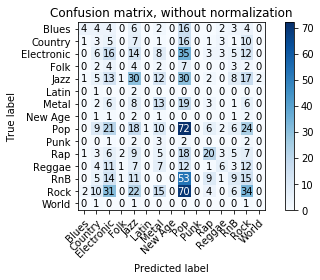

In [204]:
ax = plot_confusion_matrix(y_test, y_pred_test, classes=np.array(list(LABEL_TO_INDEX.keys())))
plt.savefig('/data/AGE_DATA/tfif.png', dpi=600, transparent=True)

In [195]:
plt.show(ax)

In [180]:
classes = np.array(list(LABEL_TO_INDEX.keys()))

In [181]:
classes

array(['Blues', 'Country', 'Electronic', 'Folk', 'Jazz', 'Latin', 'Metal',
       'New Age', 'Pop', 'Punk', 'Rap', 'Reggae', 'RnB', 'Rock', 'World'],
      dtype='<U10')

In [171]:
unique_labels(y_test, y_pred_test)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [175]:
np.array(classes)[unique_labels(y_test, y_pred_test)]

array(['Blues', 'Country', 'Electronic', 'Folk', 'Jazz', 'Latin', 'Metal',
       'New Age', 'Pop', 'Punk', 'Rap', 'Reggae', 'RnB', 'Rock', 'World'],
      dtype='<U10')

# Load preds

In [239]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [277]:
def get_preds_ft(filename, LABEL_TO_INDEX):
    with open(filename, 'r') as file:
        line = file.read()
    preds_ft = line.split("\n")[:-1]
    preds_ft = [x.replace("__label__", "") for x in preds_ft]
    preds = []
    for pred in preds_ft:
        if pred in LABEL_TO_INDEX:
            preds.append(LABEL_TO_INDEX[pred])
        else:
            #print ("Alarm!")
            preds.append(7)
    return preds

In [271]:
def read_train(filename, LABEL_TO_INDEX):
    with open(filename, 'r') as file:
        line = file.read()
    preds_ft = line.split("\n")[:-1]
    preds_ft = [x.split()[0] for x in preds_ft]
    preds_ft = [x.replace("__label__", "") for x in preds_ft]
    preds = []
    for pred in preds_ft:
        if pred in LABEL_TO_INDEX:
            preds.append(LABEL_TO_INDEX[pred])
        else:
            #print ("Alarm!")
            preds.append(7)
    return preds

In [272]:
train_target = read_train(train_file, LABEL_TO_INDEX)

In [273]:
len(train_target)

8331

In [297]:
train_file = '/home/fedor.kitashov/libraries/fastText-0.2.0/dataset_train_ft.txt'

In [298]:
train_res = '/home/fedor.kitashov/libraries/fastText-0.2.0/7_train_preds.txt'

In [299]:
val_file = '/home/fedor.kitashov/libraries/fastText-0.2.0/dataset_val_ft.txt'

In [300]:
val_res = '/home/fedor.kitashov/libraries/fastText-0.2.0/7_val_preds.txt'

In [301]:
test_file = '/home/fedor.kitashov/libraries/fastText-0.2.0/dataset_test_ft.txt'

In [302]:
test_res = '/home/fedor.kitashov/libraries/fastText-0.2.0/7_test_preds.txt'

In [303]:
train_target = read_train(train_file, LABEL_TO_INDEX)

In [304]:
train_preds_ft = get_preds_ft(train_res, LABEL_TO_INDEX)

In [305]:
len(train_preds_ft)

8331

In [306]:
print(classification_report(train_target, train_preds_ft))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       137
           1       0.00      0.00      0.00       627
           2       0.00      0.00      0.00       684
           3       0.00      0.00      0.00       304
           4       0.34      0.30      0.32       543
           5       0.67      0.78      0.72        72
           6       0.00      0.00      0.00       724
           7       0.00      0.00      0.00        42
           8       0.20      0.62      0.31      1153
           9       0.00      0.00      0.00       204
          10       0.00      0.00      0.00       646
          11       0.00      0.00      0.00       312
          12       0.00      0.00      0.00       555
          13       0.53      0.98      0.69      2296
          14       0.00      0.00      0.00        32

    accuracy                           0.38      8331
   macro avg       0.12      0.18      0.14      8331
weighted avg       0.20   

Confusion matrix, without normalization
[[   0    0    0    0   66    1    0    0   61    0    0    0    0    9
     0]
 [   0    0    0    0   14    0    0    0  398    0    0    0    0  215
     0]
 [   0    0    0    0   38    0    0    0  507    0    0    0    0  139
     0]
 [   0    0    0    0   16    0    0    0  175    0    0    0    0  113
     0]
 [   0    0    0    0  163    0    0    0  355    0    0    0    0   25
     0]
 [   0    0    0    0    5   56    0    0    7    0    0    0    0    4
     0]
 [   0    0    0    0    2    0    0    0  152    0    0    0    0  570
     0]
 [   0    0    0    0   19    8    0    0   14    0    0    0    0    1
     0]
 [   0    0    0    0    5    3    0    0  716    0    0    0    0  429
     0]
 [   0    0    0    0   20    4    0    0   86    0    0    0    0   94
     0]
 [   0    0    0    0   11    2    0    0  342    0    0    0    0  291
     0]
 [   0    0    0    0   63    4    0    0  198    0    0    0    0   47
     0]


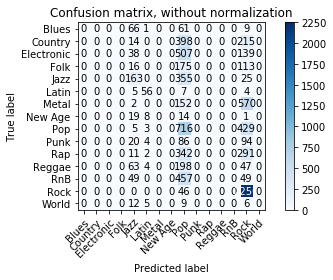

In [307]:
ax = plot_confusion_matrix(train_target, train_preds_ft, classes=np.array(list(LABEL_TO_INDEX.keys())))
plt.savefig('/data/AGE_DATA/fasttext_7.png', dpi=600, transparent=True)

In [308]:
val_target = read_train(val_file, LABEL_TO_INDEX)

In [309]:
val_preds_ft = get_preds_ft(val_res, LABEL_TO_INDEX)

In [310]:
print(classification_report(val_target, val_preds_ft))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.00      0.00      0.00        66
           2       0.00      0.00      0.00       102
           3       0.00      0.00      0.00        33
           4       0.15      0.13      0.14       105
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00       100
           7       0.00      0.00      0.00        25
           8       0.21      0.81      0.34       209
           9       0.00      0.00      0.00        21
          10       0.00      0.00      0.00        63
          11       0.00      0.00      0.00        33
          12       0.00      0.00      0.00        78
          13       0.16      0.14      0.15       137
          14       0.00      0.00      0.00         3

    accuracy                           0.20      1004
   macro avg       0.04      0.07      0.04      1004
weighted avg       0.08   

Confusion matrix, without normalization
[[  0   0   0   0   7   0   0   0  19   0   0   0   0   2   0]
 [  0   0   0   0   4   0   0   0  49   0   0   0   0  13   0]
 [  0   0   0   0  10   0   0   0  77   0   0   0   0  15   0]
 [  0   0   0   0   3   0   0   0  28   0   0   0   0   2   0]
 [  0   0   0   0  14   0   0   0  83   0   0   0   0   8   0]
 [  0   0   0   0   0   0   0   0   1   0   0   0   0   0   0]
 [  0   0   0   0   8   0   0   0  75   0   0   0   0  17   0]
 [  0   0   0   0   3   0   0   0  19   0   0   0   0   3   0]
 [  0   0   0   0  20   1   0   0 170   0   0   0   0  18   0]
 [  0   0   0   0   4   0   0   0  16   0   0   0   0   1   0]
 [  0   0   0   0   3   0   0   0  54   0   0   0   0   6   0]
 [  0   0   0   0   0   0   0   0  27   0   0   0   0   6   0]
 [  0   0   0   0   9   0   0   0  63   0   0   0   0   6   0]
 [  0   0   0   0  10   0   0   0 108   0   0   0   0  19   0]
 [  0   0   0   0   0   0   0   0   3   0   0   0   0   0   0]]


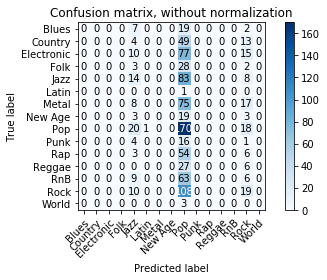

In [311]:
ax = plot_confusion_matrix(val_target, val_preds_ft, classes=np.array(list(LABEL_TO_INDEX.keys())))
plt.savefig('/data/AGE_DATA/fasttext_7_val.png', dpi=600, transparent=True)

In [312]:
test_target = read_train(test_file, LABEL_TO_INDEX)

In [313]:
test_preds_ft = get_preds_ft(test_res, LABEL_TO_INDEX)

In [315]:
print(classification_report(test_target, test_preds_ft))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        45
           1       0.00      0.00      0.00        48
           2       0.00      0.00      0.00       102
           3       0.00      0.00      0.00        24
           4       0.16      0.12      0.14       121
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00        58
           7       0.00      0.00      0.00         8
           8       0.17      0.83      0.28       169
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00        79
          11       0.00      0.00      0.00        64
          12       0.00      0.00      0.00       118
          13       0.23      0.13      0.17       194
          14       0.00      0.00      0.00         3

    accuracy                           0.17      1046
   macro avg       0.04      0.07      0.04      1046
weighted avg       0.09   

Confusion matrix, without normalization
[[  0   0   0   0   7   0   0   0  33   0   0   0   0   5   0]
 [  0   0   0   0   3   0   0   0  43   0   0   0   0   2   0]
 [  0   0   0   0   9   0   0   0  75   0   0   0   0  18   0]
 [  0   0   0   0   1   0   0   0  20   0   0   0   0   3   0]
 [  0   0   0   0  14   0   0   0  99   0   0   0   0   8   0]
 [  0   0   0   0   0   0   0   0   3   0   0   0   0   0   0]
 [  0   0   0   0   2   0   0   0  45   0   0   0   0  11   0]
 [  0   0   0   0   2   0   0   0   5   0   0   0   0   1   0]
 [  0   0   0   0  10   0   0   0 141   0   0   0   0  18   0]
 [  0   0   0   0   0   0   0   0   9   0   0   0   0   1   0]
 [  0   0   0   0   7   0   0   0  64   0   0   0   0   8   0]
 [  0   0   0   0   8   0   0   0  49   0   0   0   0   7   0]
 [  0   0   0   0  11   0   0   0 100   0   0   0   0   7   0]
 [  0   0   0   0  10   0   0   0 158   0   0   0   0  26   0]
 [  0   0   0   0   1   0   0   0   2   0   0   0   0   0   0]]


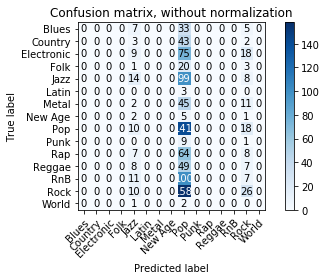

In [316]:
ax = plot_confusion_matrix(test_target, test_preds_ft, classes=np.array(list(LABEL_TO_INDEX.keys())))
plt.savefig('/data/AGE_DATA/fasttext_7_test.png', dpi=600, transparent=True)

In [253]:
test_preds_ft = get_preds_ft(test_res, LABEL_TO_INDEX)

In [254]:
len(y_val)

1004

In [255]:
print(classification_report(y_test, test_preds_ft))

              precision    recall  f1-score   support

           0       0.12      0.04      0.06        45
           1       0.09      0.12      0.11        48
           2       0.12      0.21      0.15       102
           3       0.04      0.04      0.04        24
           4       0.20      0.26      0.23       121
           5       0.00      0.00      0.00         3
           6       0.16      0.21      0.18        58
           7       0.00      0.00      0.00         8
           8       0.23      0.28      0.25       169
           9       0.00      0.00      0.00        10
          10       0.26      0.32      0.28        79
          11       0.14      0.08      0.10        64
          12       0.14      0.11      0.12       118
          13       0.22      0.10      0.14       194
          14       0.00      0.00      0.00         3

    accuracy                           0.18      1046
   macro avg       0.11      0.12      0.11      1046
weighted avg       0.18   

In [ ]:
filename
with open(filename, 'r') as file:
    line = file.read()

In [210]:
train_preds_ft = line.split("\n")

In [211]:
len(y_train)

8332

In [214]:
len(train_preds_ft)

8332

In [220]:
preds_ft = np.array([x.replace("__label__", "") for x in train_preds_ft])

In [223]:
np.array(y_train)[preds_ft == ""]

array([6])

In [217]:
np.unique(preds_ft)

array(['', 'Blues', 'Country', 'Electronic', 'Folk', 'Jazz', 'Latin',
       'Metal', 'New', 'Pop', 'Punk', 'Rap', 'Reggae', 'RnB', 'Rock',
       'World'], dtype='<U10')

In [218]:
len(np.unique(preds_ft))

16

In [219]:
LABEL_TO_INDEX

{'Blues': 0,
 'Country': 1,
 'Electronic': 2,
 'Folk': 3,
 'Jazz': 4,
 'Latin': 5,
 'Metal': 6,
 'New Age': 7,
 'Pop': 8,
 'Punk': 9,
 'Rap': 10,
 'Reggae': 11,
 'RnB': 12,
 'Rock': 13,
 'World': 14}

# Summary